In [1550]:
# Make the notebook wider
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

# TO DO LIST: 08/27/2018
- Read some of the paper more
- Create RandomForestClassifiers for the following groups of features
    - Paper Features
    - Non paper features
    - all the features
    - periodigram (1/days)
    
- Improve on the RandomForestClassifier

- actually learn about these techniques
- parameter feature importance
- hyperparameter adjustment to RFC and the result
    - no. of trees
    - minimum splits
    - number of features
    - sklearn.gridsearch
    
- run RFC, get results

### Imports

In [1633]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcdefaults()

import os
import pickle
import itertools
import random

from astropy import stats
import astropy.units as u

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Methods from Ashish's Presentation

In [1634]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

def amplitude(magnitudes):
    return 0.5 * (np.max(magnitudes) - np.min(magnitudes))

def median_absolute_deviation(magnitudes):
    median = np.median(magnitudes)
    deviations = magnitudes - median
    absolute_deviations = np.absolute(deviations)

    return np.median(absolute_deviations)

def residual_bright_faint_ratio(magnitudes):    # median as a fit
    mean = np.mean(magnitudes)

    brighter = magnitudes[magnitudes > mean]
    fainter = magnitudes[magnitudes < mean]

    resid_brighter = np.mean(np.square(brighter - mean))
    resid_fainter = np.mean(np.square(fainter - mean))

    ratio = resid_fainter / resid_brighter

    return ratio

def welch_stetson_K(magnitudes, errors):
    num_obs = magnitudes.shape[0]

    mean_mag = np.mean(magnitudes)

    a = np.sqrt(num_obs / (num_obs - 1)) * ((magnitudes - mean_mag) / errors)

    b = np.mean(np.absolute(a))
    c = np.sqrt(np.mean(np.square(a)))

    stetson_K = b / c

    return stetson_K

def gaussian_process_regression(times, magnitudes, errors):
    times_X = np.expand_dims(times, 1)
    
    gauss = GaussianProcessRegressor(alpha=1)
    gauss.fit(times_X, magnitudes)
    
    prior_mean = np.median(magnitudes)
    
    min_time = np.min(times)
    max_time = np.max(times)
    interval = (max_time - min_time) / 100.0
    
    gauss_times = np.arange(min_time, max_time, interval)
    gauss_times_X = np.expand_dims(gauss_times, 1)
    
    gauss_mags = gauss.sample_y(gauss_times_X) + prior_mean
    
    return gauss_times, gauss_mags

def total_variation(gauss_mags):
    m = gauss_mags.size

    mags_m_plus_1 = gauss_mags[1:]
    mags_m = gauss_mags[0:-1]

    abs_diffs = np.absolute(mags_m_plus_1 - mags_m)

    return np.sum(abs_diffs) / m

In [1635]:
def get_features(curve):
    times = curve[:,0]
    magnitudes = curve[:,2]
    errors = curve[:,3]
    
    ampl = amplitude(magnitudes)
    mad = median_absolute_deviation(magnitudes)
    br_fa = residual_bright_faint_ratio(magnitudes)
    stet_K = welch_stetson_K(magnitudes, errors)
    
    gauss_times, gauss_mags = gaussian_process_regression(times, magnitudes, errors)
    totvar = total_variation(gauss_mags)
    
    famp = amplitude(gauss_mags)
    
    feats = {
        "ampl": ampl,
        "mad": mad,
        "br_fa": br_fa,
        "stet_K": stet_K,
        "totvar": totvar,
        "famp": famp,
    }
    
    return feats

# START HERE! =======================================
---

In [1636]:
# Reading in the data, then dropping an extra index column
feature_df = pd.read_csv('./data/all_features.csv')
feature_df = feature_df[feature_df.columns.drop('Unnamed: 0')]

In [1637]:
# Importing the model selection module, and then setting up the 
# stratified KFold
import sklearn.model_selection as skms
skf = skms.StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [1638]:
# Dropping a few columns that are now going unused
#feature_df.head()
feature_df = feature_df[feature_df.columns.drop(['peak2_period', 'peak3_period', 'peak2_amp', 'peak3_amp'])]

# Function: scale_data
---
Used for scaling data...

In [1639]:
def scale_data(data, features, to_drop=[], log=False, log_feats=[]):
    '''scale_data standardizes the data, while giving an option
    to also apply a log10 to certain features.
    '''
    # Dropping any columns necessary (this is helpful for dropping the appropriate
    # categorical columns)
    dropped = data[to_drop]
    data = data[data.columns.drop(to_drop)]
    
    # If log scale is true, perform a log10 transform on the columns that were specified
    # in log_feats
    if log:
        log_data = np.log10(data[log_variables])
        not_log_data = data[data.columns.difference(log_variables)]
        data = pd.concat([log_data, not_log_data], axis=1, names=
                         list(log_data.columns) + list(not_log_data.columns))
    
    # Application of a standardization transform
    # The standard scaler from SKlearn
    sscaler = StandardScaler(
        with_mean=True,
        with_std=True,
    )
    
    # Setting up the data DataFrame again
    cols = data.columns
    data = pd.DataFrame(sscaler.fit_transform(data), columns=cols)
    data = pd.concat([data, dropped], axis=1,)
    
    return data

In [1640]:
log_variables = ['ampl','br_fa','famp','mad','totvar','autocor','eta','peak1_period', 'peak1_amp', 'pTime','pAmp']

feature_df = scale_data(feature_df, features=features, to_drop=['EPIC', 'VType'], log=True, log_feats=log_variables)

In [1641]:
X = feature_df[features].values
y = feature_df['VType']
skf.get_n_splits(X, y);

In [1642]:
# Getting only the feature NAMES from the headers, not the data
features = feature_df.columns.drop(['EPIC', 'VType'])

# Function: plot_confusion_matrix
---
You can find this one [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-pyhttp://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) ...

In [1643]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [1659]:
# Setting up the data sets...
data_set = []
Y_PREDICT = []
Y_TEST = []

feature_importances = []

# Main loop for doing Random Forest Classification
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    data_set.append({"X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test})
    
    clf = RandomForestClassifier(n_estimators=100) 
    clf = clf.fit(X_train, y_train)
    
    y_predict = clf.predict(X_test)
    
    y_predict = np.asarray(y_predict)
    y_predict.shape = (len(y_predict),)
    y_predict = y_predict.tolist()
    Y_PREDICT += y_predict

    y_test = np.asarray(y_test)
    y_test.shape = (len(y_test),)
    y_test = y_test.tolist()
    Y_TEST += y_test
    
    if i == 0:
        for val in clf.feature_importances_:
            feature_importances.append(val)
            
    else:
        for j, val in enumerate(clf.feature_importances_):
            feature_importances[j] += val
            
    
feature_importances = np.divide(feature_importances, i+1)

print("{:>12} \tIMPORTANCE".format('FEATURE'))
for feat, imp in zip(features, feature_importances):
    print('{:>12}\t{}'.format(feat, imp))

    
# Setting up a feature_importance data frame
feat_imp = pd.DataFrame(feature_importances.reshape(1, len(feature_importances)), columns=features)

print(80*'-')
print('{:>12}\t{}'.format('SUM',np.sum(feature_importances)))

rf_score = metrics.accuracy_score(Y_PREDICT, Y_TEST)
print('{:>12}\t{}'.format('ACCURACY', rf_score))

     FEATURE 	IMPORTANCE
        ampl	0.040049267186269215
       br_fa	0.10890685309667625
        famp	0.037169733830598746
         mad	0.03379393793030869
      totvar	0.03526717811805292
     autocor	0.04797860597407275
         eta	0.050352778557373266
peak1_period	0.03036954279423676
   peak1_amp	0.05116714781621114
       pTime	0.08692419742209245
        pAmp	0.04833263135597168
           M	0.1785613815928062
           Q	0.1624397885126866
num_sigpeaks	0.014137330941534729
      stet_K	0.07454962487110857
--------------------------------------------------------------------------------
         SUM	0.9999999999999999
    ACCURACY	0.7395833333333334


In [1645]:
print(pd.Series(Y_TEST).value_counts())
print(pd.Series(Y_PREDICT).value_counts())


QPS    77
QPD    49
APD    45
B      39
S      22
P      19
MP     15
N      11
L       8
U       3
dtype: int64
QPS    94
B      49
APD    47
QPD    46
S      23
P      15
L       7
N       5
MP      2
dtype: int64


In [1646]:
classes = feature_df.VType.unique()

Normalized confusion matrix
[[0.8974359  0.07692308 0.         0.         0.         0.
  0.         0.02564103 0.         0.        ]
 [0.05194805 0.84415584 0.         0.05194805 0.01298701 0.
  0.02597403 0.01298701 0.         0.        ]
 [0.18181818 0.         0.27272727 0.         0.         0.09090909
  0.         0.36363636 0.         0.09090909]
 [0.02040816 0.10204082 0.         0.73469388 0.         0.12244898
  0.         0.02040816 0.         0.        ]
 [0.         0.21052632 0.         0.05263158 0.68421053 0.05263158
  0.         0.         0.         0.        ]
 [0.         0.02222222 0.         0.08888889 0.         0.84444444
  0.         0.04444444 0.         0.        ]
 [0.         0.86666667 0.         0.06666667 0.06666667 0.
  0.         0.         0.         0.        ]
 [0.27272727 0.13636364 0.         0.         0.         0.04545455
  0.         0.54545455 0.         0.        ]
 [0.33333333 0.         0.66666667 0.         0.         0.
  0.         0. 

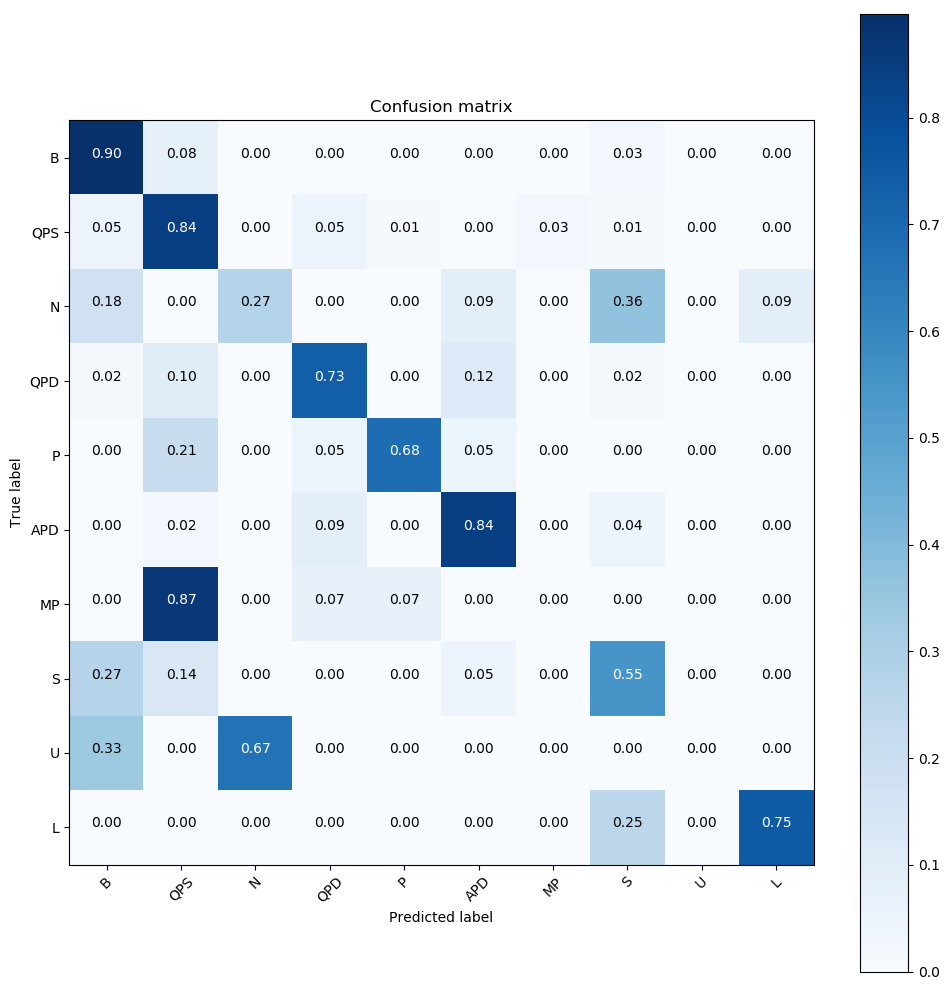

In [1647]:
#plt.subplots(figsize=(10,10))
#plot_confusion_matrix(metrics.confusion_matrix(Y_TEST, Y_PREDICT, classes), classes)
plt.subplots(figsize=(10,10))
plot_confusion_matrix(metrics.confusion_matrix(Y_TEST, Y_PREDICT, classes), classes, normalize=True)

In [1648]:
with open('data_set.obj', 'wb') as f:
    pickle.dump(data_set, f)
    

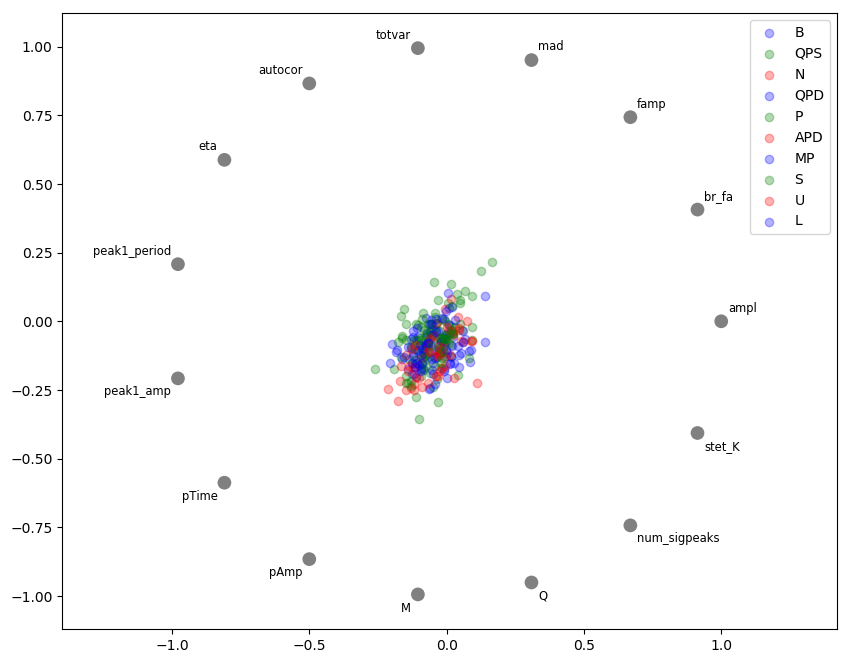

In [1649]:
plt.rcdefaults() 
fig, ax = plt.subplots(figsize = (10, 8))
pd.plotting.radviz(feature_df[feature_df.columns.drop(['EPIC'])], 'VType', ax, color = ('b', 'g', 'r'), alpha = 0.3);

In [1576]:
print(feature_df.columns.drop('VType'))

Index(['ampl', 'br_fa', 'famp', 'mad', 'totvar', 'autocor', 'eta',
       'peak1_period', 'peak1_amp', 'pTime', 'pAmp', 'M', 'Q', 'num_sigpeaks',
       'stet_K', 'EPIC'],
      dtype='object')


In [1577]:
from sklearn import decomposition

#iris = np.array(dfIris.drop(columns = ['species']))
#species = dfIris['species']
#iris_colors = {'setosa': 'b', 'versicolor': 'g', 'virginica': 'r'}


pca = decomposition.PCA(n_components=7)
feat_arr = np.array(feature_df[features])
pca.fit(feat_arr)
features_pca = pca.transform(feat_arr)
print(features_pca)
print(pca.explained_variance_ratio_) 



[[-1.95569431 -1.2733137   0.52922214 ...  0.07823885 -0.27089467
   0.92078308]
 [ 3.07872701  1.44339466 -0.60209523 ...  4.58430809  0.21543124
  -0.79800097]
 [-3.27351745  0.02452073 -0.47573031 ...  0.99712377 -0.49221463
   1.4059502 ]
 ...
 [ 4.00884825 -0.34709088 -0.14552951 ... -0.76157906  1.68609963
   0.31219561]
 [ 1.18492665  1.35166338  0.99523802 ... -0.10666919  0.63094311
   0.08586847]
 [ 2.54388337 -1.51256915  0.61091324 ... -0.42593391  0.35039886
   1.0215219 ]]
[0.29914721 0.16544366 0.12151761 0.09958913 0.08375453 0.06097612
 0.05226658]


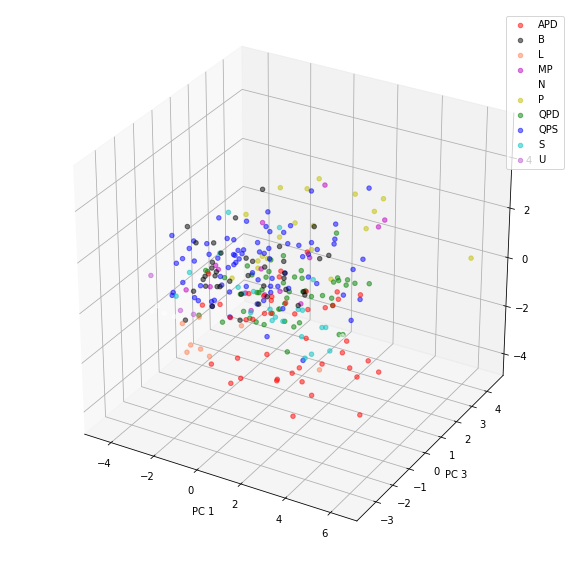

In [1594]:
from ipywidgets import widgets
from IPython.display import display
%matplotlib inline
data_colors = {'QPS': 'b', 'QPD': 'g', 'APD': 'r', 'B':'k', 'S':'c', 'P':'y', 'MP':'m', 
               'N':'w', 'L':'coral', 'U':'mediumorchid'}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for i in np.unique(y):
    mask = (y == i)
    ax.scatter(features_pca[mask][:, 0], features_pca[mask][:, 1], features_pca[mask][:,2], label = i, c = data_colors[i], alpha = 0.5)
    
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_ylabel("PC 3")
ax.legend()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 288 but corresponding boolean dimension is 10

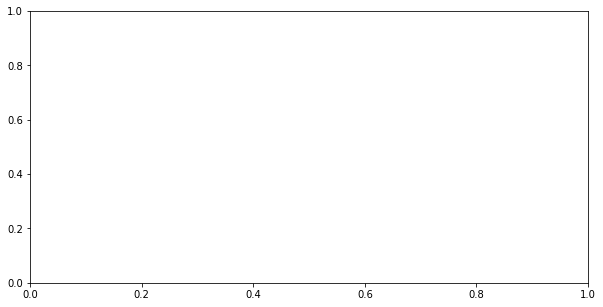

In [1588]:
## loading vectors
#eviris = 2. * pca.components_
#for idx, var in enumerate(features.columns[:-1]):
#    ax.plot([0, eviris[0, idx]], [0, eviris[1, idx]])
#    ax.text(eviris[0, idx], eviris[1, idx], var)
#ax.set_xlabel("PCA 1")
#ax.set_ylabel("PCA 2")
#ax.legend();

In [ ]:
vil = np.transpose(pd.DataFrame([pd.Series(feature_df_scaled.columns),pd.Series(clf.feature_importances_)]))
vil.sort_values(by=1)